In [118]:
# Source: https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape, rmse
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [136]:
# Load full training dataset
training_data = pd.read_csv('./data/training_data.csv')

/var/folders/pr/s8vz2jrj0gzcy0cb3dtmqx800000gn/T/ipykernel_84533/596541118.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  training_data = pd.read_csv('./data/training_data.csv')


In [137]:
# Important! Due to the large size of the dataset only import a subset to test the code

# Load approx half of the available data
training_data = training_data[0:4780]
training_data.columns = training_data.columns.str.lower()
training_data = training_data.drop(columns=['name', 'last_sale','sales','presale'])

In [138]:
# Function to merge 2 dictionaries
def merge(d1, d2):
    result = {**d1, **d2}
    return result

In [139]:
# Function to one hot encode the data
def one_hot_encode_data(dataset):
    # One hot encode data
    from sklearn.preprocessing import OneHotEncoder
    col_to_encode = dataset[['owner', 'mouth', 'eyes', 'hat', 'fur', 'background', 'clothes', 'earring']]
    col_to_encode.fillna('Other', inplace=True)

    X = col_to_encode
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    enc.fit(X)

    col_names = ['owner', 'mouth', 'eyes', 'hat', 'fur', 'background', 'clothes', 'earring']
    colnames = enc.get_feature_names(col_names)
    encoded_data =  pd.DataFrame(enc.fit_transform(X), columns = colnames)

    dataset_temp = dataset.drop(columns=col_names)
    dataset_dic = dataset_temp.to_dict('list')
    encoded_data_dic = encoded_data.to_dict('list')

    encoded_data_final = merge(encoded_data_dic, dataset_dic)
    encoded_data_final = pd.DataFrame.from_dict(encoded_data_final)

    traget_index = encoded_data_final.columns.get_loc("eth_sale price")
    print('done')
    return encoded_data_final, traget_index

In [140]:
encoded_train_data = one_hot_encode_data(training_data)[0]
#encoded_test_data = one_hot_encode_data(test_data)[0]
#train_target_index = one_hot_encode_data(training_data)[1]

done


/var/folders/pr/s8vz2jrj0gzcy0cb3dtmqx800000gn/T/ipykernel_84533/562302766.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_to_encode.fillna('Other', inplace=True)
/Users/jb/opt/anaconda3/envs/DartMachineLearning/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [141]:
# Save encoded training data
#encoded_train_data.to_csv('./data/encoded_train_data.csv', index=False)

In [142]:
# Convert data to darts timeseries data and splitt datasets into individual data
def convert_to_timeseries(data):
    grouped = data.groupby(['token_id'])
    l_grouped = list(grouped)
    target_timeseries_list = []
    covariates_timeseries_list = []
    lenght_data = len(l_grouped)
    for i in range(0,lenght_data):
        single_nft = l_grouped[i][1].reset_index(drop=True)
        #print(single_nft['token_id'])
        index = pd.DatetimeIndex(single_nft['timestamp'])
        single_nft = single_nft.set_index(index)
        single_nft = single_nft.drop(['timestamp'],axis=1)
        single_nft = single_nft[~single_nft.index.duplicated(keep='first')]
        col_names = single_nft.columns
        sc = MinMaxScaler(feature_range=(0,1))
        single_nft_scaled = sc.fit_transform(single_nft)
        single_nft_scaled = pd.DataFrame(single_nft_scaled, columns=col_names)
        single_nft_scaled_ts = TimeSeries.from_dataframe(single_nft_scaled,fill_missing_dates=True,freq='D')
        train_eth_price = single_nft_scaled_ts['eth_sale price']
        col_names = col_names.tolist()
        col_names.remove('eth_sale price')
        target_timeseries_list.append(train_eth_price)
        single_nft_scaled = single_nft_scaled.drop(['eth_sale price'],axis=1)
        train_covariates_ts = TimeSeries.from_values(single_nft_scaled)
        covariates_timeseries_list.append(train_covariates_ts)
    return target_timeseries_list, covariates_timeseries_list

In [143]:
# Create datasets as timeseries from encoded data
train_target = convert_to_timeseries(encoded_train_data)[0]
train_covars = convert_to_timeseries(encoded_train_data)[1]
print('done')

done


In [144]:
# Create train and test data
test_target = train_target[0:5]
test_covars = train_covars[0:5]
train_target = train_target[5:20]
train_covars = train_covars[5:20]

In [127]:
# Optinal: Use full dataset instead of single nft datasets
#sc = MinMaxScaler(feature_range=(0,1))
#encoded_traning_data_full = encoded_traning_data_temp.drop(['timestamp'],axis=1)
#train_eth_price_scaled_all = sc.fit_transform(encoded_traning_data_full)
#train_timeseries_list[1]['eth_sale price']
#train_eth_price_scaled_temp = train_eth_price_scaled_all[:,60]
#train_covariates_all = np.delete(train_eth_price_scaled_all, np.s_[:60], axis=1)
#print('lenght: target ',len(train_eth_price_scaled_all))
#print('lenght: covariates ',len(train_covariates_all))

In [145]:
# Build the model and fit the model
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=10,
    random_state=0,
)

model_cov.fit(
    series=train_target,
    past_covariates=train_covars,
    verbose=True,
)

[2022-06-10 19:13:49,198] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3060 samples.
[2022-06-10 19:13:49,198] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3060 samples.
2022-06-10 19:13:49 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 3060 samples.
[2022-06-10 19:13:49,207] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-10 19:13:49,207] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-10 19:13:49 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-06-10 19:13:49,210] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Light

Training: 0it [00:00, ?it/s]

In [152]:
predict_target = test_target[2]
predict_covars = test_covars[2]
# Full set data
#predict_target = train_covariates_ts[1]
#predict_covars = train_eth_price_scaled_ts[1]

Predicting: 96it [00:00, ?it/s]

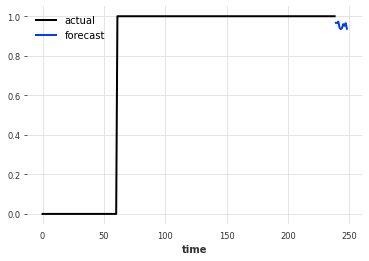

In [153]:
pred_cov = model_cov.predict(n=10,series=predict_target,past_covariates=predict_covars)
predict_target .plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()

In [163]:
def backtrack_testing(target, covars):
    backtest_cov = model_cov.historical_forecasts(
        target,
        past_covariates=covars,
        start=0.12,
        forecast_horizon=12,
        stride=1,
        retrain=False,
        verbose=False,
    )
    return backtest_cov

In [165]:
backtest_cov_list = []
for i in range(0,5):
    target = test_target[i]
    covars = test_covars[i]
    backtest_pred = backtrack_testing(target, covars)
    backtest_cov_list.append(backtest_pred)

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

Predicting: 96it [00:00, ?it/s]

In [84]:
#list(training_data['token_id'].value_counts())

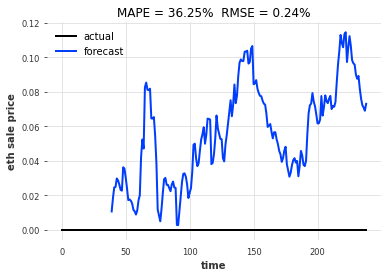

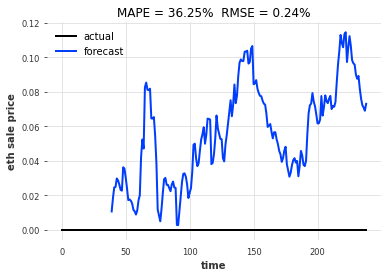

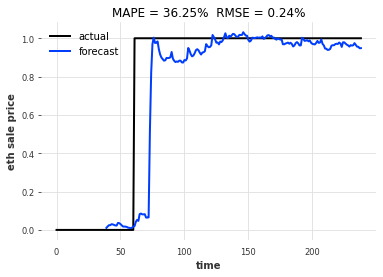

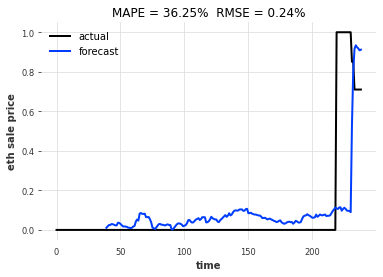

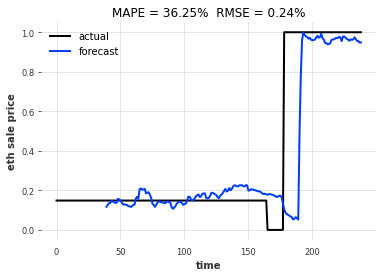

In [184]:
for i in range(len(backtest_cov_list)):
    mape_value = "MAPE = {:.2f}%".format(smape(predict_target, backtest_cov))
    rmse_value = "RMSE = {:.2f}%".format(rmse(predict_target, backtest_cov))
    target = test_target[i]
    fig, axs = plt.subplots()
    fig.patch.set_facecolor('white')
    target.plot(label="actual")
    backtest_cov_list[i].plot(label="forecast")
    plt.ylabel('eth sale price')
    plt.legend()
    plt.title(mape_value+'  '+rmse_value)